# Knife MI analysis

In [1]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm as tqdm
import numpy as np
import json
import sklearn

from utils import get_features
from models.model_paths import get_model_path

In [87]:
DATASET = "ClinTox"
LENGTH = 2048
MDS_DIM = 64

DESCRIPTORS = [
            "ecfp",
            "electroshape",
            "estate",
            "fcfp",
            "erg",
            "rdkit",
            "topological",
            "avalon",
            "maccs",
            "secfp",
            "scaffoldkeys",
            "usr",
            "usrcat",
            "cats",
            "gobbi",
            "pmapper",
            "cats/3D",
            "gobbi/3D",
            "pmapper/3D",
        ]

with open(f"data/{DATASET}/smiles.json", "r") as f:
    smiles = json.load(f)

100%|██████████| 19/19 [00:00<00:00, 20.85it/s]


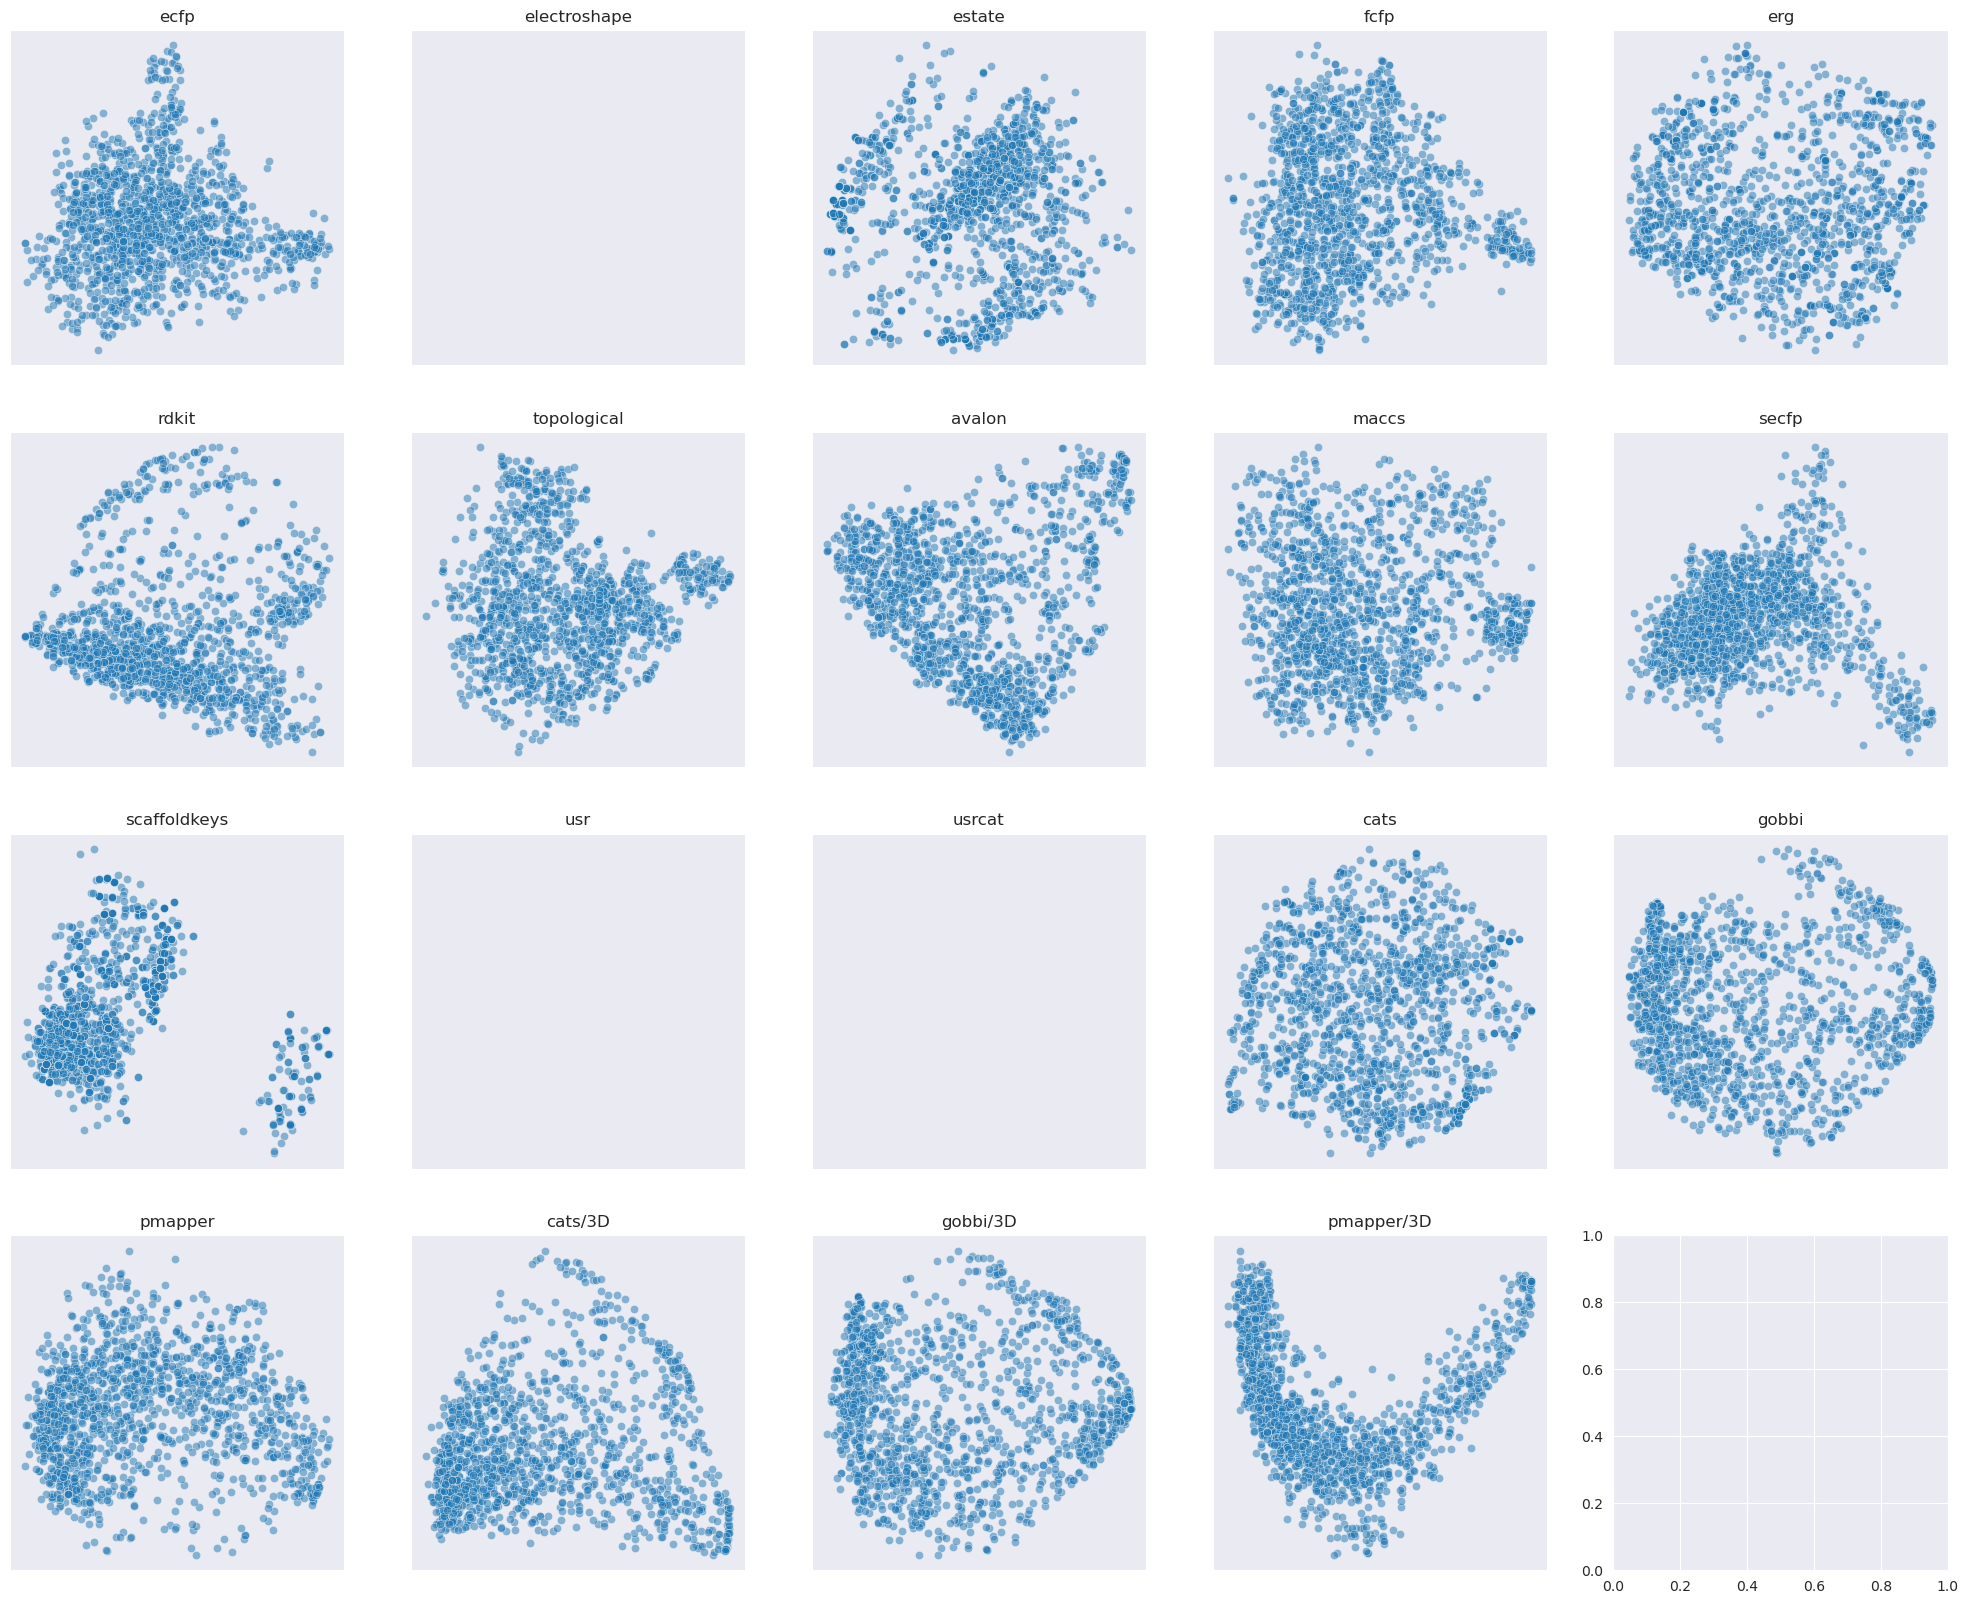

In [88]:
FIGSIZE = 5
fig,axes = plt.subplots(4,5,figsize=(FIGSIZE*5,FIGSIZE*4))
axes = axes.flatten()

for i,d in enumerate(tqdm(DESCRIPTORS)):
    if os.path.exists(f"data/{DATASET}/{d.replace('/','_')}_{LENGTH}_mds_{MDS_DIM}.npy"):
        embeddings = np.load(f"data/{DATASET}/{d.replace('/','_')}_{LENGTH}_mds_{MDS_DIM}.npy")
        pca = sklearn.decomposition.PCA(n_components=2)
        embeddings_red = pca.fit_transform(embeddings)
        #tsne = sklearn.manifold.TSNE(n_components=2, n_iter=250)
        #embeddings_red = tsne.fit_transform(embeddings_red)
        df = pd.DataFrame(embeddings_red, columns=["PC1", "PC2"])
        df["smiles"] = smiles
        sns.scatterplot(data=df, x="PC1", y="PC2",alpha=0.5, ax=axes[i])
    axes[i].set_title(d)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [36]:
models_pca = ["ChemBertMLM-5M", "ChemBertMTR-5M", "EdgePred","GraphMVP", "AttributeMask","Not-trained"]
MODELS = get_model_path(models=models_pca)

1453 torch.Size([1453, 600])


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1453 torch.Size([1453, 384])


/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


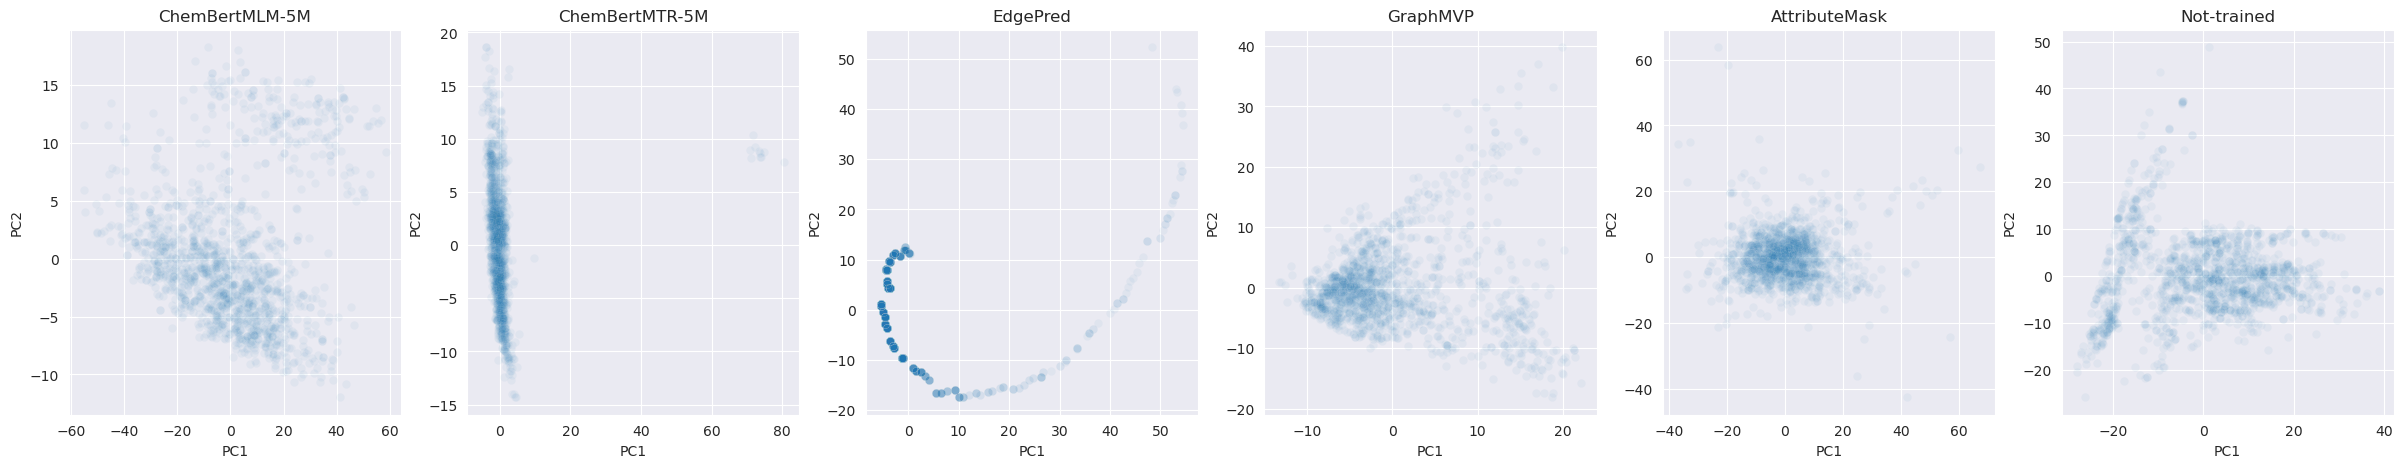

In [37]:
fig,axes = plt.subplots(1,len(models_pca),figsize=(len(models_pca)*5,5))
for i,model in enumerate(models_pca):
    embeddings = get_features(smiles, name=model, length=LENGTH, mds_dim=MDS_DIM, dataset=DATASET, feature_type="model", normalize=True, path = MODELS.get(model, None))
    # nromalize embeddings
    embeddings = (embeddings - embeddings.mean(axis=0))/(embeddings.std(axis=0) +1e-8)
    pca = sklearn.decomposition.PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    df = pd.DataFrame(embeddings_pca, columns=["PC1", "PC2"])
    df["smiles"] = smiles
    sns.scatterplot(data=df, x="PC1", y="PC2",alpha=0.05, ax = axes[i])
    axes[i].set_title(model)



In [89]:
full_df_loss_cond = []
full_df_loss_marg = []

for file in tqdm(os.listdir("results/losses")):
    #one plot for each model showing the loss on all descriptors. Files are {model}_{descriptor}_{run}_XY.csv
    if file.endswith(".csv"):
        file_split = file[:-4].split("_")
        if file_split[0] == DATASET and file_split[-2] == str(LENGTH):
            if file_split[-1] == "marg":
                model, descriptor = file.split("_")[:2]
                df_tmp = pd.read_csv(os.path.join("results/losses", file))
                full_df_loss_marg.append(df_tmp)
            else:
                model, descriptor = file.split("_")[:2]
                df_tmp = pd.read_csv(os.path.join("results/losses", file))
                full_df_loss_cond.append(df_tmp)

full_df_loss_cond = pd.concat(full_df_loss_cond)
full_df_loss_marg = pd.concat(full_df_loss_marg)


100%|██████████| 20/20 [00:00<00:00, 23.38it/s]


ValueError: No objects to concatenate

<AxesSubplot:xlabel='epoch', ylabel='marg_ent'>

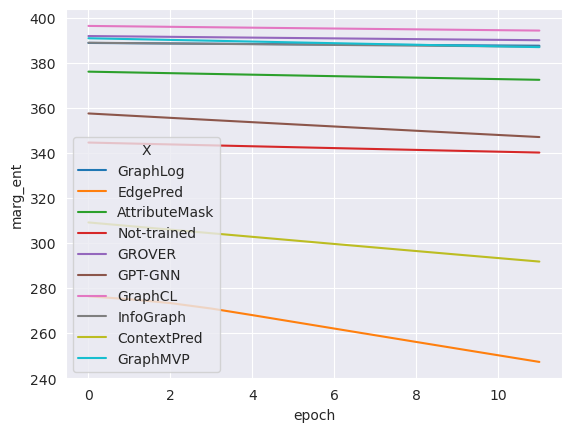

In [44]:
sns.lineplot(data=full_df_loss_marg, x="epoch", y="marg_ent", hue="X")

In [57]:
full_df_loss_cond

,cond_ent,epoch,run,X,Y,direction
0,443.474843,0,0,ContextPred,GPT-GNN,X->Y
1,389.632298,1,0,ContextPred,GPT-GNN,X->Y
2,309.930193,2,0,ContextPred,GPT-GNN,X->Y
3,257.173544,3,0,ContextPred,GPT-GNN,X->Y
4,241.961985,4,0,ContextPred,GPT-GNN,X->Y
...,...,...,...,...,...,...
375,297.977483,33,0,Not-trained,GraphLog,X->Y
376,280.036422,34,0,Not-trained,GraphLog,X->Y
377,278.127244,35,0,Not-trained,GraphLog,X->Y
378,273.441208,36,0,Not-trained,GraphLog,X->Y


In [63]:
# remove EdgePred
full_df_loss_cond = full_df_loss_cond[full_df_loss_cond.Y != "EdgePred"]
full_df_loss_cond = full_df_loss_cond[full_df_loss_cond.X != "EdgePred"]

full_df_loss_margin = full_df_loss_marg[full_df_loss_marg.X != "EdgePred"]

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


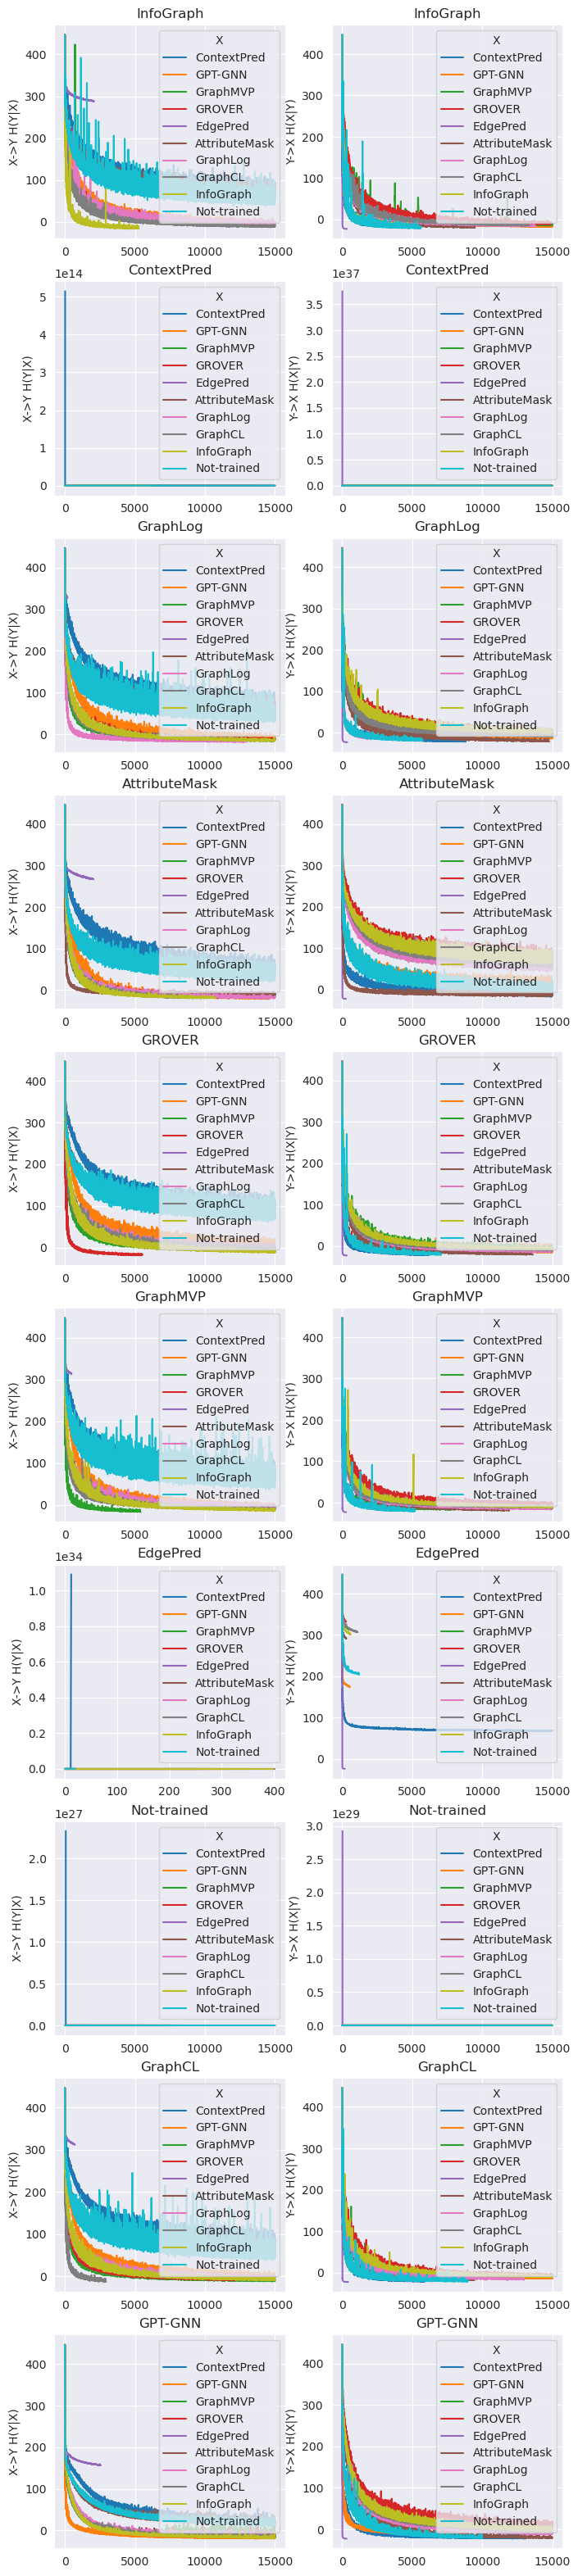

In [90]:
n_rows = full_df_loss_cond.Y.nunique()
n_cols = 2
fig, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*4,4*n_rows))


for i, model in enumerate(tqdm(full_df_loss_cond.Y.unique())):
    df_tmp = full_df_loss_cond[(full_df_loss_cond.Y == model) & (full_df_loss_cond.direction == "X->Y")]
    sns.lineplot(data=df_tmp, x="epoch", y="cond_ent", hue="X", ax=axes[i,0], estimator=None, errorbar= None, n_boot=0, legend=True)
    axes[i,0].set_title(model)
    axes[i,0].set_xlabel("")
    axes[i,0].set_ylabel("X->Y H(Y|X)")

    df_tmp = full_df_loss_cond[(full_df_loss_cond.Y == model) & (full_df_loss_cond.direction == "Y->X")]

    sns.lineplot(data=df_tmp, x="epoch", y="cond_ent", hue="X", ax=axes[i,1], estimator=None, errorbar= None, n_boot=0, legend=True)
    axes[i,1].set_title(model)
    axes[i,1].set_xlabel("")
    axes[i,1].set_ylabel("Y->X H(X|Y)")


## MI between descriptors and embeddings

In [91]:
import os
import numpy as np
all_df = []
for file in os.listdir("results"):
    if file.endswith(".csv"):
        file_split = file[:-4].split("_")
        if file_split[0] == DATASET and file_split[-1] == str(LENGTH):
            all_df.append(pd.read_csv(os.path.join("results", file)))
df = pd.concat(all_df)

In [92]:
df[df.isna().any(axis=1)]

,X,Y,I(Y),I(Y|X),I(X->Y),I(X),I(X|Y),I(Y->X),Y_dim,X_dim,is_desc_discrete
0,ContextPred2048,Not-trained,592.857335,NaN,NaN,116.311648,-11.957693,128.269341,300,300,False
4,EdgePred2048,Not-trained,592.857335,197.004708,395.852626,-20.600208,NaN,NaN,300,300,False
0,ContextPred2048,EdgePred,-20.600208,NaN,NaN,116.311645,68.390500,47.921146,300,300,False
9,Not-trained2048,EdgePred,-20.600208,NaN,NaN,593.111014,204.095857,389.015158,300,300,False
0,ContextPred2048,ContextPred,116.311645,NaN,NaN,116.311644,NaN,NaN,300,300,False
4,EdgePred2048,ContextPred,116.311645,67.694022,48.617622,-20.600208,NaN,NaN,300,300,False


In [94]:
df = df[
        ~(df.X.isin(["EdgePred2048", "ContextPred2048"]) | df.Y.isin(["EdgePred", "ContextPred"]))
]


## Clustermap

In [106]:
df["I(Y->X)/dim"] = df["I(Y->X)"]/df["X_dim"]
df["I(X->Y)/dim"] = df["I(X->Y)"]/df["Y_dim"]

df["I(Y->X)/I(X)"] = df["I(Y->X)"]/df["I(X)"]
df["I(X->Y)/I(Y)"] = df["I(X->Y)"]/df["I(Y)"]



df["I(Y->X) - I(X->Y)"] =  df["I(Y->X)"]-df["I(X->Y)"]
df["I(Y->X)/dim - I(X->Y)/dim"] = df["I(Y->X)/dim"]-df["I(X->Y)/dim"]
df["I(Y->X)/I(X) - I(X->Y)/I(Y)"] = df["I(Y->X)/I(X)"]-df["I(X->Y)/I(Y)"]


df = df.dropna()

In [96]:
df = df[df.Y!= "EdgePred"]

In [97]:
keys = [
    "I(Y->X)", "I(X->Y)", "I(Y->X)/dim", "I(X->Y)/dim",
    "I(Y->X) - I(X->Y)", "I(Y->X)/dim - I(X->Y)/dim",
]

for key in keys:
    df[key + "_normed"] = df.apply(lambda x: x[key] - df[(df.Y == "Not-trained") & (df.X == x.X)][key].values[0], axis=1)


<AxesSubplot:xlabel='X_dim', ylabel='I(Y->X)/I(X)'>

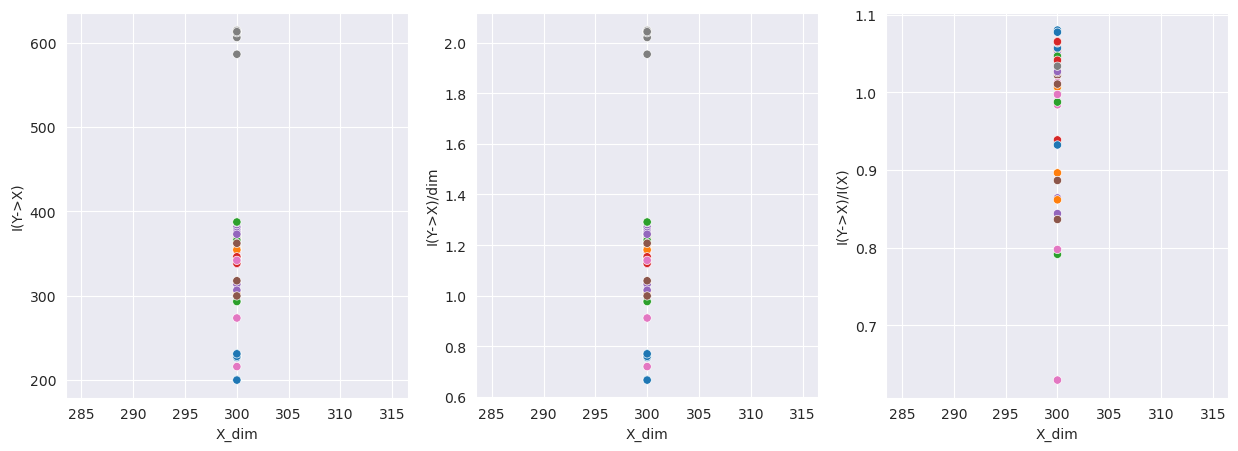

In [98]:
%matplotlib inline

fig,axes = plt.subplots(1,3,figsize=(15, 5), sharex=True)

sns.scatterplot(data=df, y="I(Y->X)", x="X_dim", hue="X", ax=axes[0], legend=False)

sns.scatterplot(data=df, y="I(Y->X)/dim", x="X_dim", hue="X", ax=axes[1], legend=False)

sns.scatterplot(data=df, y="I(Y->X)/I(X)", x="X_dim", hue="X", ax=axes[2], legend=False)


<AxesSubplot:xlabel='Y_dim', ylabel='I(X->Y)/I(Y)'>

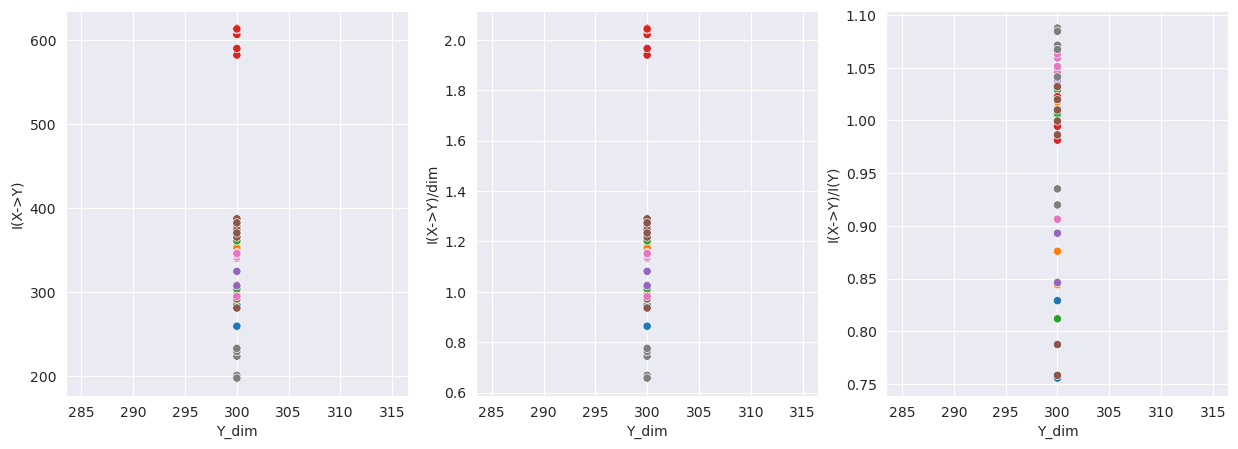

In [99]:
%matplotlib inline

fig,axes = plt.subplots(1,3,figsize=(15, 5), sharex=True)

sns.scatterplot(data=df, y="I(X->Y)", x="Y_dim", hue="Y", ax=axes[0], legend=False)
sns.scatterplot(data=df, y="I(X->Y)/dim", x="Y_dim", hue="Y", ax=axes[1], legend=False)
sns.scatterplot(data=df, y="I(X->Y)/I(Y)", x="Y_dim", hue="Y", ax=axes[2], legend=False)


In [107]:
def plot_cmap(df, keys, cmap = "copper", vmin = None, vmax = None, center = None):

    for i, key in enumerate(keys):
        cluster = sns.clustermap(
            df.pivot_table(index="X", columns="Y", values=key, aggfunc="mean"),
            cmap=cmap, figsize=(8,8), vmin=vmin, vmax=vmax, center=center
        )
        cluster.savefig("fig/cluster_{}.png".format(i))
        plt.clf()

    import matplotlib.image as mpimg

    fig, axes = plt.subplots(1,len(keys), figsize=(8*len(keys),8))
    for i, key in enumerate(keys):
        axes[i].imshow(mpimg.imread("fig/cluster_{}.png".format(i)))
        axes[i].axis("off")
        axes[i].set_title(key)
    plt.show()

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

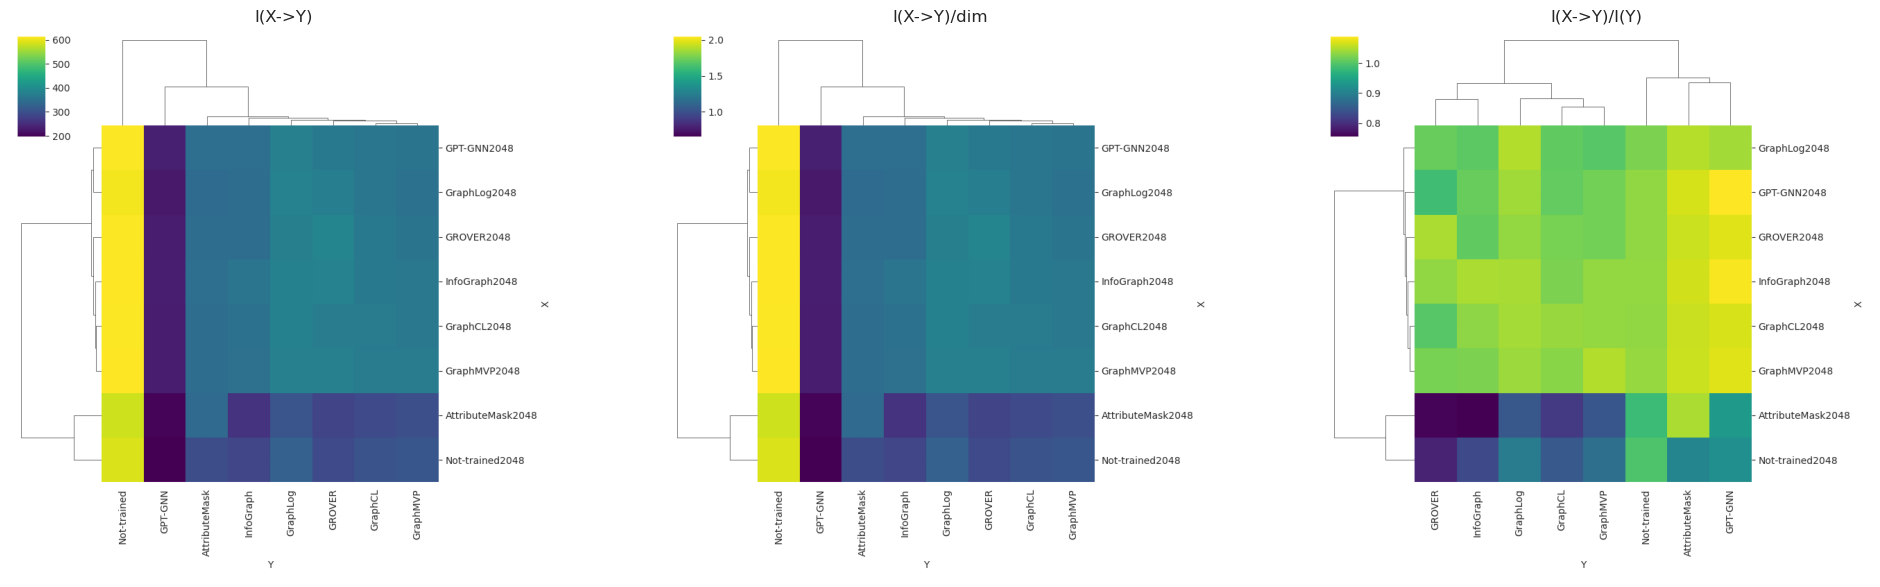

In [108]:
%matplotlib inline
plot_cmap(
    df[df.X_dim>30],
    ["I(X->Y)", "I(X->Y)/dim", "I(X->Y)/I(Y)"],
    cmap="viridis"
)

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

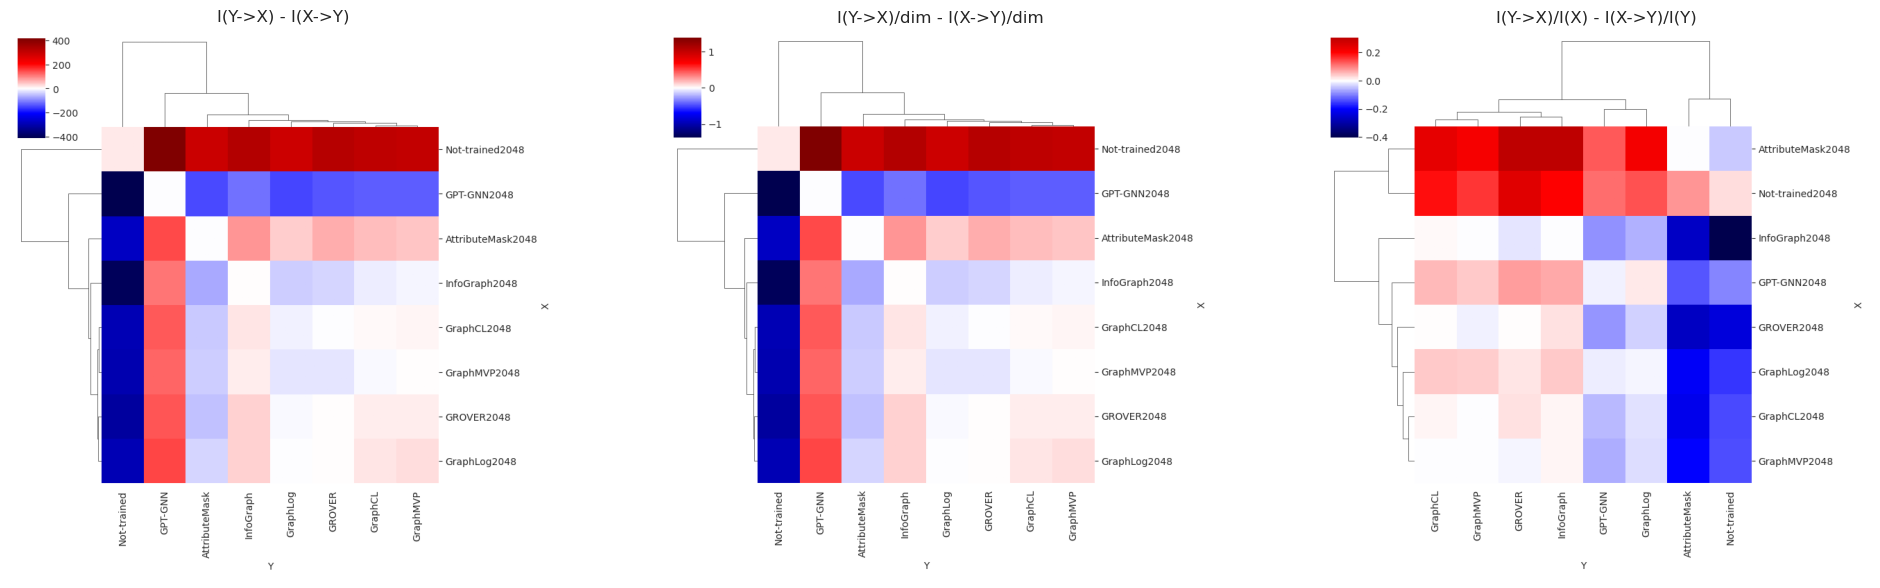

In [112]:
plot_cmap(
    df[df.X_dim>30],
    ["I(Y->X) - I(X->Y)", "I(Y->X)/dim - I(X->Y)/dim", "I(Y->X)/I(X) - I(X->Y)/I(Y)"],
    cmap="seismic",
    center=0
)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(data=df, x="X", y="I(Y->X)", hue="Y")

In [ ]:
sns.boxplot(data=df[df.Y != "Not-trained"], x="X", y="I(Y->X)", hue="Y")

# Fine-tuning

In [ ]:
!pip install networkx==2.8.8

In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html --force

In [ ]:
import os
from tdc.single_pred import Tox

from sklearn.model_selection import train_test_split
import datamol as dm
import pandas as pd
import numpy as np
import torch

from evaluation import get_dataloaders, Feed_forward
from precompute_3d import precompute_3d

df = Tox(name="ClinTox").get_data()
mols, smiles = precompute_3d(df["Drug"].to_numpy(), "ClinTox")
valid_indices = []
mols_valid = []
i_mol = 0
for i,s in enumerate(df["Drug"]):
    if dm.to_smiles(dm.to_mol(s), True, False) in smiles and not "*" in s:
        df["Drug"].iloc[i] = dm.to_smiles(dm.to_mol(s), True, False)
        valid_indices.append(i)
        mols_valid.append(mols[i_mol])
        i_mol += 1

df = df.iloc[valid_indices]
df["Mol"] = mols_valid

smiles = df["Drug"].to_numpy()
y = df["Y"].to_numpy()

df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
df.sample(5)

In [ ]:
def run_expe(model_path = "backbone_pretrained_models/GraphLog/Contextual.pth", desc_name="", n_epochs = 100, plot=False):
    dataloader_train, dataloader_test, input_dim = get_dataloaders(smiles_train, y_train, smiles_test, y_test, desc_name=desc_name, model_path=model_path)
    model = Feed_forward(
        input_dim = input_dim,
        hidden_dim = 128,
        output_dim = 1,
        n_layers = 1,
        d_rate=0.3,
        norm="batch"
    )
    model.train_model(dataloader_train, dataloader_test, n_epochs=n_epochs)
    model_name = "None" if model_path=="None" else model_path.split("/")[-2] + " "
    if plot:
        model.plot_loss(title = model_name + " " + desc_name)
    return model

In [ ]:
descriptors = [
            "physchem",
            "ecfp-count",
            "ecfp",
            "estate",
            "erg",
            "rdkit",
            "topological",
            "avalon",
            "maccs",
            "scaffoldkeys",
            "cats",
            "default",
            "gobbi",
            "pmapper",
            "cats/3D",
            "gobbi/3D",
            "pmapper/3D",
        ]

In [ ]:
df_mi = pd.read_csv("resultsClinTox.csv").groupby(["X", "Y"])["I(X->Y)"].mean()

In [ ]:
from tqdm import tqdm
df_desc = {"descriptor":[], "best_acc": [], "best_f1":[], "best_roc":[], "best_aucpr":[]}

N_RUNS = 5
p_bar = tqdm(total=len(descriptors) * N_RUNS, desc="Fine tuning",position=0, leave=True)

for d in descriptors:
        dataloader_train, dataloader_test, input_dim = get_dataloaders(
            df_train.Drug, y_train, df_test.Drug, y_test,df_train["Mol"], df_test["Mol"], desc_name=d, model_path="None")
        for _ in range(N_RUNS):
            df_desc["descriptor"].append(d)
            model = Feed_forward(
                input_dim = input_dim,
                hidden_dim = 128,
                output_dim = 1,
                n_layers = 1,
                d_rate=0.3,
                norm="batch"
            )
            model.train_model(dataloader_train, dataloader_test, n_epochs=300)
            best_acc = np.max(model.test_acc)
            df_desc["best_acc"].append(best_acc)
            df_desc["best_f1"].append(np.max(model.test_f1))
            df_desc["best_roc"].append(np.max(model.test_roc))
            df_desc["best_aucpr"].append(np.max(model.test_aucpr))
            p_bar.update(1)



In [ ]:
df_desc = pd.DataFrame(df_desc)
df_desc


In [ ]:
MODEL_PATH = "backbone_pretrained_models"
MODELS = {}
# For every directory in the folder
for model_name in os.listdir(MODEL_PATH):
    # For every file in the directory
    for file_name in os.listdir(os.path.join(MODEL_PATH, model_name)):
        # If the file is a .pth file
        if file_name.endswith(".pth"):
            MODELS[model_name] = os.path.join(MODEL_PATH, model_name, file_name)
MODELS["Not-trained"] = ""

In [ ]:
from tqdm import tqdm
df_model = {"model":[], "best_acc": [], "best_f1":[], "best_roc":[], "best_aucpr":[]}

N_RUNS = 5
p_bar = tqdm(total=len(MODELS) * N_RUNS, desc="Fine tuning",position=0, leave=True)

for model_name, model_path in MODELS.items():
        dataloader_train, dataloader_test, input_dim = get_dataloaders(
            df_train.Drug, y_train, df_test.Drug, y_test,df_train["Mol"], df_test["Mol"], desc_name="None", model_path=model_path)
        for _ in range(N_RUNS):
            df_model["model"].append(model_name)
            model = Feed_forward(
                input_dim = input_dim,
                hidden_dim = 128,
                output_dim = 1,
                n_layers = 1,
                d_rate=0.3,
                norm="batch"
            )
            model.train_model(dataloader_train, dataloader_test, n_epochs=300)
            best_acc = np.max(model.test_acc)
            df_model["best_acc"].append(best_acc)
            df_model["best_f1"].append(np.max(model.test_f1))
            df_model["best_roc"].append(np.max(model.test_roc))
            df_model["best_aucpr"].append(np.max(model.test_aucpr))
            p_bar.update(1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1,figsize=(32,16))
for i,metric in enumerate(["best_f1", "best_roc", "best_aucpr"]):
    sns.barplot(data=df_desc.sort_values("best_aucpr"), x="descriptor", y=metric, hue="descriptor", ax = axes[i])
    axes[i].set_ylim(max(0,df_desc[metric].min()-0.05), min(1,df_desc[metric].max() + 0.05))
plt.show()

In [ ]:
df_model = pd.DataFrame(df_model)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1,figsize=(32,16))
for i,metric in enumerate(["best_f1", "best_roc", "best_aucpr"]):
    sns.barplot(data=df_model.sort_values("best_aucpr"), x="model", y=metric, hue="model", ax = axes[i])
    axes[i].set_ylim(max(0,df_desc[metric].min()-0.05), min(1,df_desc[metric].max() + 0.05))
plt.show()

In [ ]:
df_model

In [ ]:
df_mi

In [ ]:
df_mi = pd.read_csv("resultsClinTox.csv")
df_mi["I(X->Y)_normed"] = df_mi.apply(lambda x: x["I(X->Y)"] - df_mi[(df.Y == "Not-trained") & (df_mi.X == x.X)]["I(X->Y)"].values[0], axis=1)
df_mi["I(Y->X)_normed"] = df_mi.apply(lambda x: x["I(Y->X)"] - df_mi[(df.Y == "Not-trained") & (df_mi.X == x.X)]["I(Y->X)"].values[0], axis=1)


In [ ]:
hue_order = df_model.model.unique()
fig, axess = plt.subplots(len(descriptors),3,figsize=(3*7,len(descriptors)*7))
first = True
for descriptor, axes in zip(descriptors, axess):
    df_plot = df_model[~(df_model.model.isin(["Not-trained", "EdgePred"]))].merge(df_mi, left_on="model", right_on="Y").drop(columns=["Y"]).rename(columns={"X":"descriptor"})
    df_plot = df_plot[df_plot.descriptor == descriptor]
    for i,(metric, ax) in enumerate(zip(["best_f1", "best_roc", "best_aucpr"], axes)):
        #Scatterplot with linear regression amd corr-coefficient
        sns.regplot(data=df_plot, y=metric, x="I(X->Y)_normed", ax =ax, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
        #display correlation coefficient
        corr = df_plot[[metric, "I(X->Y)_normed"]].corr().iloc[0,1]
        ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
        ax.set_title("I(X->Y)_normed " + descriptor + " " + str(df_desc[df_desc.descriptor == descriptor][metric].mean())[:4])


plt.show()

In [ ]:
hue_order = df_model.model.unique()
fig, axess = plt.subplots(len(descriptors),3,figsize=(3*7,len(descriptors)*7))
first = True
for descriptor, axes in zip(descriptors, axess):
    df_plot = df_model[~(df_model.model.isin(["Not-trained", "EdgePred"]))].merge(df_mi, left_on="model", right_on="Y").drop(columns=["Y"]).rename(columns={"X":"descriptor"})
    df_plot = df_plot[df_plot.descriptor == descriptor]
    for i,(metric, ax) in enumerate(zip(["best_f1", "best_roc", "best_aucpr"], axes)):
        #Scatterplot with linear regression amd corr-coefficient
        sns.regplot(data=df_plot, y=metric, x="I(Y->X)_normed", ax =ax, scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
        #display correlation coefficient
        corr = df_plot[[metric, "I(Y->X)_normed"]].corr().iloc[0,1]
        ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')

        ax.set_title("I(Y->X)_normed " +descriptor + " " + str(df_desc[df_desc.descriptor == descriptor][metric].mean())[:4])
plt.show()

We now also consider a score that aggregates all MIs by suming all normalized MIs weigthed with the descriptor's best performance


In [ ]:
df_plot = df_model[~(df_model.model.isin(["Not-trained", "EdgePred"]))].merge(df_mi, left_on="model", right_on="Y").drop(columns=["Y"]).rename(columns={"X":"descriptor"})
df_tmp_descriptors = df_desc.rename(columns={k: k+"_desc" for k in ["best_f1", "best_roc", "best_aucpr"]})
df_plot = df_plot.merge(df_tmp_descriptors, left_on="descriptor", right_on="descriptor")
df_plot["sum_I(X->Y)_item"] = df_plot["I(X->Y)_normed"] * df_plot["best_aucpr_desc"]
df_plot["sum_I(Y->X)_item"] = df_plot["I(Y->X)_normed"] * df_plot["best_aucpr_desc"]

sum_values = df_plot.groupby("model")[["sum_I(X->Y)_item", "sum_I(Y->X)_item"]].sum().reset_index().rename(columns={"sum_I(X->Y)_item":"sum_I(X->Y)", "sum_I(Y->X)_item":"sum_I(Y->X)"})

df_plot = df_plot.merge(sum_values, left_on="model", right_on="model")


In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="sum_I(X->Y)", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "sum_I(X->Y)"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "$\sum_{desc\in descriptors} [\mathcal{I} ( desc->model ) - \mathcal{I}(desc->model_{NT})$] metric$(desc)$"
)

fig.suptitle("$\mathcal{I} ( desc->model )$ score's correlation to the best performance of each evaluated model")

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="sum_I(Y->X)", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "sum_I(Y->X)"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "$\sum_{desc\in descriptors} [\mathcal{I} ( model-> desc) - \mathcal{I}(model_{NT} -> desc)$] metric$(desc)$"
)

fig.suptitle("$\mathcal{I} ( model-> desc)$ score's correlation to the best performance of each evaluated model")

In [ ]:
df_plot["compression"] = df_plot["sum_I(Y->X)"] - df_plot["sum_I(X->Y)"]

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="compression", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "compression"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "$\sum_{desc\in descriptors} [\mathcal{I} ( model-> desc) - \mathcal{I}(model_{NT} -> desc)$] metric$(desc)$"
)

fig.suptitle("$\mathcal{I} ( model-> desc)$ score's correlation to the best performance of each evaluated model")

In [ ]:
df_plot["compression_dummy"] = (df_plot["sum_I(X->Y)"] - df_plot["sum_I(X->Y)"].max())/(df_plot["sum_I(X->Y)"].min() - df_plot["sum_I(X->Y)"].max()) - (df_plot["sum_I(Y->X)"] - df_plot["sum_I(Y->X)"].max())/(df_plot["sum_I(Y->X)"].min() - df_plot["sum_I(Y->X)"].max())

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20, 5), sharex=True)
for i, (ax, metric) in enumerate(zip(axes, ["best_f1", "best_roc", "best_aucpr"])):
    sns.scatterplot(data=df_plot, y=metric, x="compression_dummy", hue="model", palette="Set3", alpha=0.5, ax=ax, legend=i==0)
    #corr coefficient
    corr = df_plot[[metric, "compression_dummy"]].corr().iloc[0,1]
    ax.text(0.05, 0.95, "corr: " + str(corr)[:4], transform=ax.transAxes, fontsize=14, verticalalignment='top')
    ax.set_xlabel("")
    ax.set_ylabel(metric.split("_")[1])

axes[1].set_xlabel(
    "Weird compression stuff"
)

fig.suptitle("Really weird compression stuff")

In [ ]:
from torch_geometric.datasets import ZINC

In [ ]:
dataset = ZINC(root='/tmp/ZINC', subset=True, split='val')

In [ ]:
from tdc_dataset import get_dataset

In [ ]:
def get_dataset(dataset: str):
    try:
        df = correspondancy_dict[dataset](name=dataset).get_data()
    except:
        label_list = retrieve_label_name_list(dataset)
        df = correspondancy_dict[dataset](name=dataset, label_name=label_list[0]).get_data()
    return df

In [ ]:
df = get_dataset("QM7b")